In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import json
import requests

import wrangle
import prepare as prep

from env import github_token, github_username

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split

import re
import unicodedata
import nltk

plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')

## Acquire and Prep

In [2]:
df = pd.read_json("data.json")
df.head()

,repo,language,readme_contents
0,mcastrolab/Brazil-Covid19-e0-change,R,# Reduction in life expectancy in Brazil after...
1,jschoeley/de0anim,R,# Animated annual changes in life-expectancy\n...
2,sychi77/Thoracic_Surgery_Patient_Survival,Jupyter Notebook,# Thoracic Surgery for Lung Cancer Data Set\n ...
3,ashtad63/HackerRank-Data-Scientist-Hiring-Test,Jupyter Notebook,# HackerRank Data Scientist Hiring Test: Predi...
4,OxfordDemSci/ex2020,R,"<p align=""center"">\n <img src=""https://github..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             166 non-null    object
 1   language         157 non-null    object
 2   readme_contents  166 non-null    object
dtypes: object(3)
memory usage: 4.0+ KB


In [4]:
df_test = df.copy()

In [5]:
def basic_clean_no_numbers(text):
    """
    Basic cleaning of text
    """
    text = (
        unicodedata.normalize("NFKD", text)
        .encode("ascii", "ignore")
        .decode("utf-8", "ignore")
    )
    text = re.sub(r"[^a-zA-Z'\s]", '', text).lower()
    return text

In [6]:
df[df['readme_contents'].str.len() == 0].shape[0]

26

In [7]:
df_copy = df.copy()

In [8]:
df = prep.prep_data(df)
df.head()

,repo,language,original,clean,more_clean,char_count,word_count,unique_word_count
0,mcastrolab/Brazil-Covid19-e0-change,R,# Reduction in life expectancy in Brazil after...,reduction life expectancy brazil covid provide...,reduction life expectancy brazil covid provide...,2949,352,211
1,jschoeley/de0anim,R,# Animated annual changes in life-expectancy\n...,animated annual changes lifeexpectancy illustr...,animated annual change lifeexpectancy illustra...,166,16,16
2,sychi77/Thoracic_Surgery_Patient_Survival,Python,# Thoracic Surgery for Lung Cancer Data Set\n ...,thoracic surgery lung cancer data set uci mach...,thoracic surgery lung cancer data set uci mach...,2058,234,150
3,ashtad63/HackerRank-Data-Scientist-Hiring-Test,Python,# HackerRank Data Scientist Hiring Test: Predi...,hackerrank data scientist hiring test predict ...,hackerrank data scientist hiring test predict ...,1011,135,86
4,OxfordDemSci/ex2020,R,"<p align=""center"">\n <img src=""https://github...",p aligncenter img srchttpsgithubcomoxforddemsc...,p aligncenter img srchttpsgithubcomoxforddemsc...,2261,233,174


In [9]:
df['clean_contents']= df['original'].apply(basic_clean_no_numbers)
df.head()

,repo,language,original,clean,more_clean,char_count,word_count,unique_word_count,clean_contents
0,mcastrolab/Brazil-Covid19-e0-change,R,# Reduction in life expectancy in Brazil after...,reduction life expectancy brazil covid provide...,reduction life expectancy brazil covid provide...,2949,352,211,reduction in life expectancy in brazil after ...
1,jschoeley/de0anim,R,# Animated annual changes in life-expectancy\n...,animated annual changes lifeexpectancy illustr...,animated annual change lifeexpectancy illustra...,166,16,16,animated annual changes in lifeexpectancy\n\n...
2,sychi77/Thoracic_Surgery_Patient_Survival,Python,# Thoracic Surgery for Lung Cancer Data Set\n ...,thoracic surgery lung cancer data set uci mach...,thoracic surgery lung cancer data set uci mach...,2058,234,150,thoracic surgery for lung cancer data set\n f...
3,ashtad63/HackerRank-Data-Scientist-Hiring-Test,Python,# HackerRank Data Scientist Hiring Test: Predi...,hackerrank data scientist hiring test predict ...,hackerrank data scientist hiring test predict ...,1011,135,86,hackerrank data scientist hiring test predict...
4,OxfordDemSci/ex2020,R,"<p align=""center"">\n <img src=""https://github...",p aligncenter img srchttpsgithubcomoxforddemsc...,p aligncenter img srchttpsgithubcomoxforddemsc...,2261,233,174,p aligncenter\n img srchttpsgithubcomoxfordde...


In [10]:
test = df.clean_contents[0]
test

' reduction in life expectancy in brazil after covid\n\n\nhere we provide the data and pipeline for  reduction in life expectancy in brazil after covidhttpsdoiorgsz\n\n citation\n\n castro mc gurzenda s turra cm et al reduction in life expectancy in brazil after covid nat med  httpsdoiorgsz\n\n\n abstract\n\nbrazil has been heavily impacted by covid we use data on reported total deaths in  and in janapr  to measure and compare the death toll across states we estimate a decline in  life expectancy at birth e of  years a mortality level not seen since  the reduction in life expectancy at age  e in  was  year setting brazil back to  levels the decline was larger for males widening by  the femalemale gap in e among states amazonas lost  of the improvements in e since  in the first four months of  covid deaths represented  of the total  figures assuming that death rates would have been equal to  allcause rates in the absence of covid covid deaths in  have already reduced e in  by  years whi

In [11]:
df.language.value_counts()

other     65
Python    48
R         31
HTML      22
Name: language, dtype: int64

In [12]:
df_all_languages = prep.prep_data(df_copy, keep_top_languages=False)

In [13]:
df_all_languages.language.value_counts()

Python         67
R              31
HTML           22
JavaScript     16
Stata           5
Java            3
Dart            3
Scala           2
Swift           2
MATLAB          1
Shell           1
TypeScript      1
Ruby            1
Objective-C     1
Scheme          1
Name: language, dtype: int64

## Split Data

In [14]:
def split_data(df):
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
    return train, validate, test

In [15]:
train, validate, test = split_data(df)
train.shape, validate.shape, test.shape

((92, 9), (40, 9), (34, 9))

In [16]:
train_languages, validate_languages, test_languages = split_data(df_all_languages)
train_languages.shape

(92, 8)

## Explore 
#### Pre-Processing

In [17]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(train, "language")

,n,percent
other,35,0.380435
Python,28,0.304348
HTML,15,0.163043
R,14,0.152174


In [59]:
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r"[^a-zA-Z'\s]", '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]


In [60]:
## Create lists of words for each language category
other = clean(' '.join(train[train.language == 'other'].original))
python = clean(' '.join(train[train.language == 'Python'].original))
r = clean(' '.join(train[train.language == 'R'].original))
html = clean(' '.join(train[train.language == 'HTML'].original))
all_words = clean(' '.join(train.original))

In [61]:
## Transform lists into series
other_freq = pd.Series(other).value_counts()
python_freq = pd.Series(python).value_counts()
r_freq = pd.Series(r).value_counts()
html_freq = pd.Series(html).value_counts()
all_freq = pd.Series(all_words).value_counts()

other_freq.head(10)

feature       99
life          71
expectancy    65
data          59
file          52
set           37
using         34
float         33
used          30
value         30
dtype: int64

In [62]:
python_freq.head(10)

life          87
expectancy    80
data          72
country       58
factor        44
model         34
health        31
img           28
dataset       27
regression    25
dtype: int64

In [63]:
r_freq.head(10)

life          34
expectancy    31
data          26
health        19
year          17
covid         11
country       11
code          11
death         10
variable       9
dtype: int64

In [64]:
html_freq.head(10)

life          29
expectancy    27
file          25
data          16
rmd           14
html          12
survival      11
death         11
project       11
median        11
dtype: int64

In [65]:
#Create a word_counts data frame we can work with

word_counts = (pd.concat([all_freq, other_freq, python_freq, r_freq, html_freq], axis=1, sort=True)
                .set_axis(['all', 'other', 'python', 'r', 'html'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,other,python,r,html
'above',1,1,0,0,0
'add,1,1,0,0,0
'configctdpointsnumber',1,1,0,0,0
'data,1,0,0,1,0
'india',3,3,0,0,0


### Answer questions about word frequency:

**What are the most frequently occuring words?**

In [66]:
word_counts.sort_values(by='all', ascending=False).head(20)

,all,other,python,r,html
life,221,71,87,34,29
expectancy,203,65,80,31,27
data,173,59,72,26,16
feature,121,99,22,0,0
country,107,28,58,11,10
file,89,52,6,6,25
health,62,9,31,19,3
model,60,18,34,6,2
year,59,11,23,17,8
factor,57,3,44,8,2


Text(0.5, 1.0, 'Word Count for top 5 Most Frequent Overall Words')

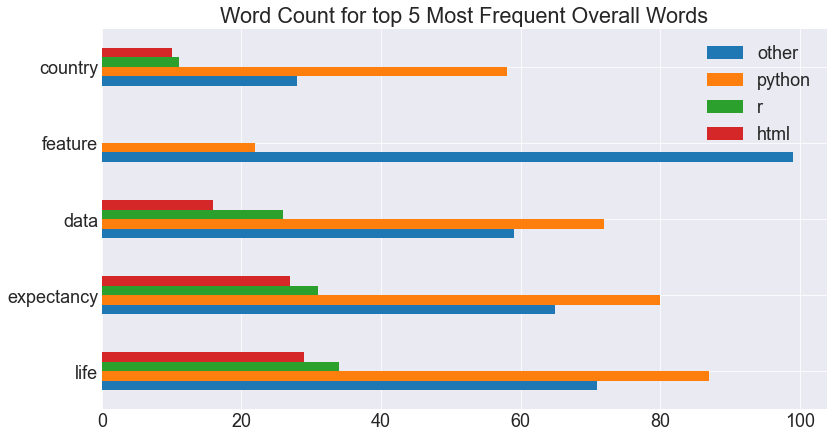

In [67]:
plt.rc('font', size=18)
word_counts.sort_values('all', ascending=False).head(5)[['other', 'python', 'r', 'html']].plot.barh()
plt.title('Word Count for top 5 Most Frequent Overall Words')

Text(0.5, 1.0, '% of Language Frequency for the most common 20 words')

<Figure size 1152x648 with 0 Axes>

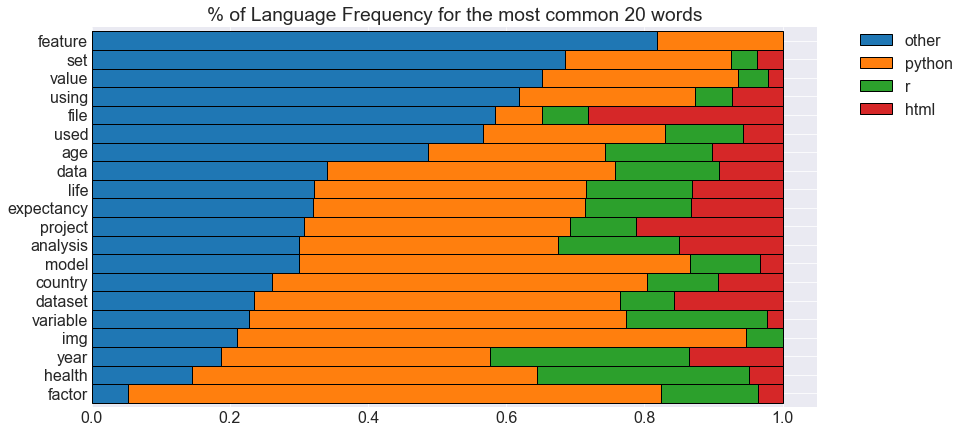

In [68]:
plt.figure(figsize=(16, 9))
plt.rc('font', size=16)

(word_counts.sort_values('all', ascending=False)
 .head(20)
 .apply(lambda row: row/row['all'], axis = 1)
 .drop(columns = 'all')
 .sort_values(by = 'other')
 .plot.barh(stacked = True, width = 1, ec = 'k')
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('% of Language Frequency for the most common 20 words')

Text(0.5, 1.0, '% of Top 10 Word Frequency by Language')

<Figure size 1152x648 with 0 Axes>

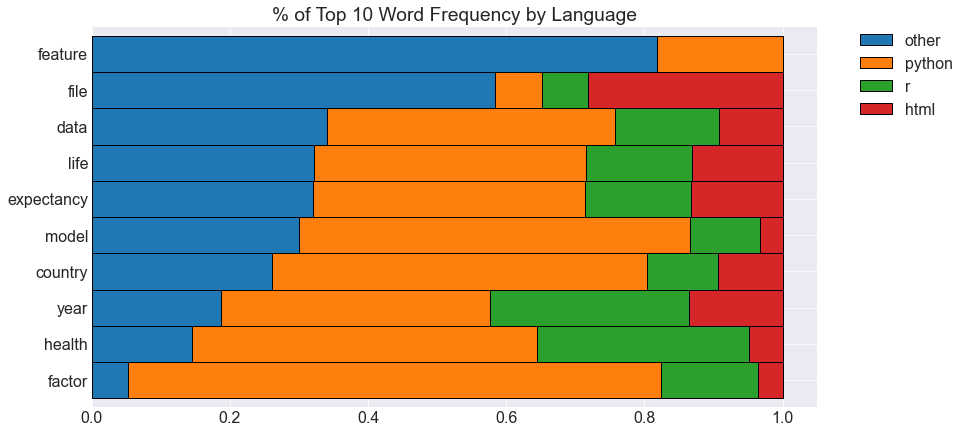

In [69]:
plt.figure(figsize=(16, 9))
plt.rc('font', size=16)

(word_counts.sort_values('all', ascending=False)
 .head(10)
 .apply(lambda row: row/row['all'], axis = 1)
 .drop(columns = 'all')
 .sort_values(by = 'other')
 .plot.barh(stacked = True, width = 1, ec = 'k')
)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('% of Top 10 Word Frequency by Language')

Text(0.5, 1.0, '% of Language Frequency for the most common 5 words')

<Figure size 1152x648 with 0 Axes>

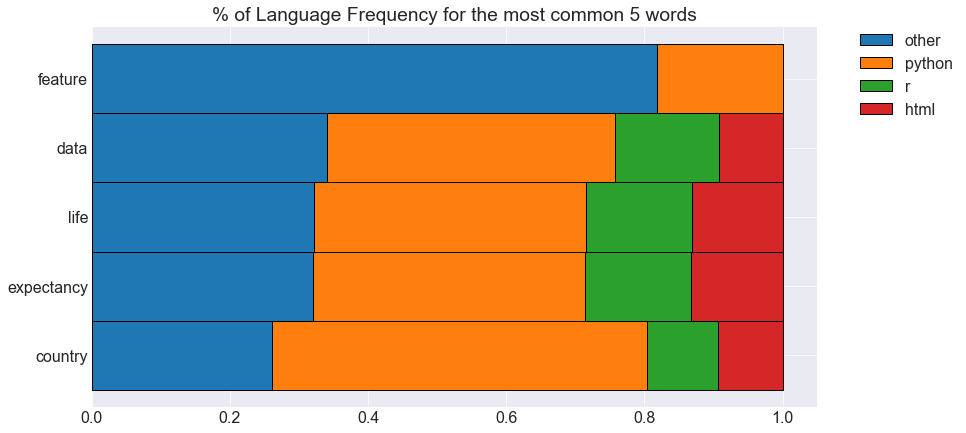

In [70]:
plt.figure(figsize=(16, 9))
plt.rc('font', size=16)

(word_counts.sort_values('all', ascending=False)
 .head(5)
 .apply(lambda row: row/row['all'], axis = 1)
 .drop(columns = 'all')
 .sort_values(by = 'other')
 .plot.barh(stacked = True, width = 1, ec = 'k')
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('% of Language Frequency for the most common 5 words')

**Are there any words that uniquely identify one of the coding languages?**

In [95]:
unique_words = pd.concat(([word_counts[word_counts.other == 0].sort_values(by='other').tail(6),
           word_counts[word_counts.python == 0].sort_values(by='python').tail(6),
           word_counts[word_counts.r == 0].sort_values(by='r').tail(6),
           word_counts[word_counts.html == 0].sort_values(by='html').tail(6)])

In [97]:
unique_words.drop_duplicates()

,all,other,python,r,html
false,1,0,0,0,1
fall,3,0,3,0,0
failed,1,0,1,0,0
federation,2,0,2,0,0
fictional,1,1,0,0,0
femalemale,1,0,0,1,0
female,7,7,0,0,0
zip,3,3,0,0,0
feature,121,99,22,0,0


Text(0.5, 1.0, 'Proportion of Language Word Frequency for the 20 most common words')

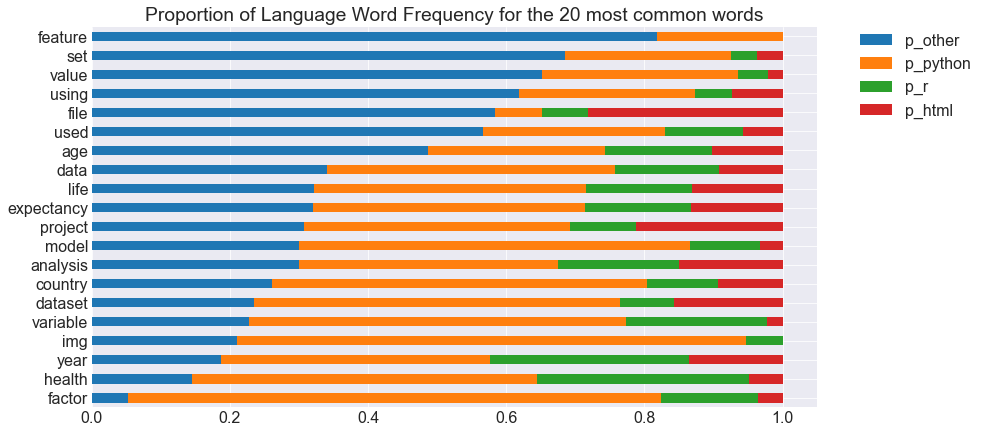

In [72]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_other=word_counts.other / word_counts['all'],
         p_python=word_counts.python / word_counts['all'],
         p_r=word_counts.r / word_counts['all'],
         p_html=word_counts.html / word_counts['all'])
 .sort_values(by='all')
 [['p_other', 'p_python', 'p_r', 'p_html']]
 .tail(20)
 .sort_values('p_other')
 .plot.barh(stacked=True))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.title('Proportion of Language Word Frequency for the 20 most common words')


### Create and Visualize Bigrams

In [73]:
# Top 20 other
top_20_other_bigrams = (pd.Series(nltk.ngrams(other, 2))
                      .value_counts()
                      .head(20))

top_20_other_bigrams.head()

(life, expectancy)    64
(file, life)          15
(sex, age)            15
(expectancy, sex)     14
(survival, rate)      12
dtype: int64

In [74]:
# Top 20 python 
top_20_python_bigrams = (pd.Series(nltk.ngrams(python, 2))
                      .value_counts()
                      .head(20))

top_20_python_bigrams.head()

(life, expectancy)     79
(machine, learning)    13
(img, width)           10
(p, aligncenter)        9
(aligncenter, img)      9
dtype: int64

In [75]:
# Top 20 r
top_20_r_bigrams = (pd.Series(nltk.ngrams(r, 2))
                      .value_counts()
                      .head(20))

top_20_r_bigrams.head()

(life, expectancy)          31
(change, life)               5
(per, populationobjectn)     5
(global, health)             5
(reduction, life)            4
dtype: int64

In [76]:
# Top 20 html
top_20_html_bigrams = (pd.Series(nltk.ngrams(html, 2))
                      .value_counts()
                      .head(20))

top_20_html_bigrams.head()

(life, expectancy)    27
(rmd, file)           14
(mean, median)        10
(median, survival)     8
(html, file)           7
dtype: int64

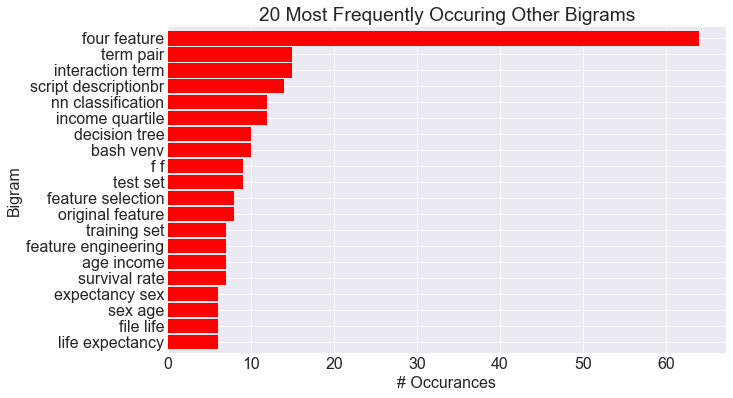

In [77]:
## Plot Top 20 Other

top_20_other_bigrams.sort_values().plot.barh(color='red', width=.9, figsize=(10, 6))

plt.title('20 Most Frequently Occuring Other Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_other_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


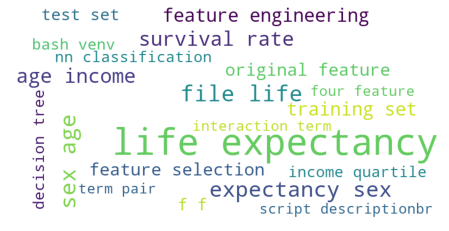

In [78]:
## Create a wordcloud 
data = {k[0] + ' ' + k[1]: v for k, v in top_20_other_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

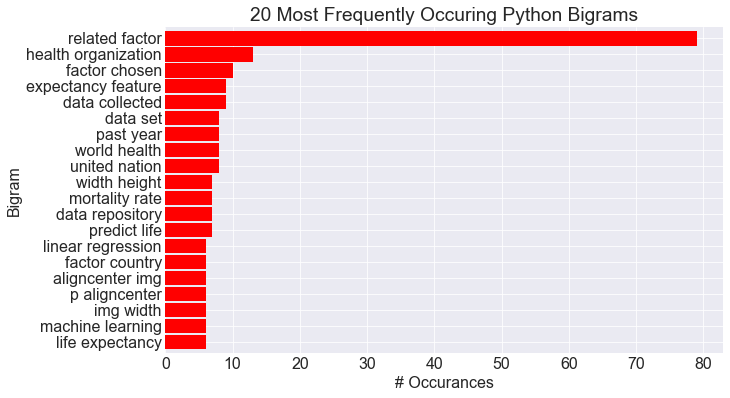

In [79]:
## Plot Top 20 python

top_20_python_bigrams.sort_values().plot.barh(color='red', width=.9, figsize=(10, 6))

plt.title('20 Most Frequently Occuring Python Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_python_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


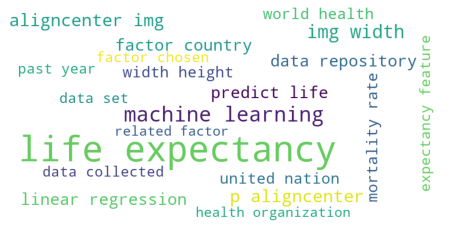

In [80]:
## Create a wordcloud 
data = {k[0] + ' ' + k[1]: v for k, v in top_20_python_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

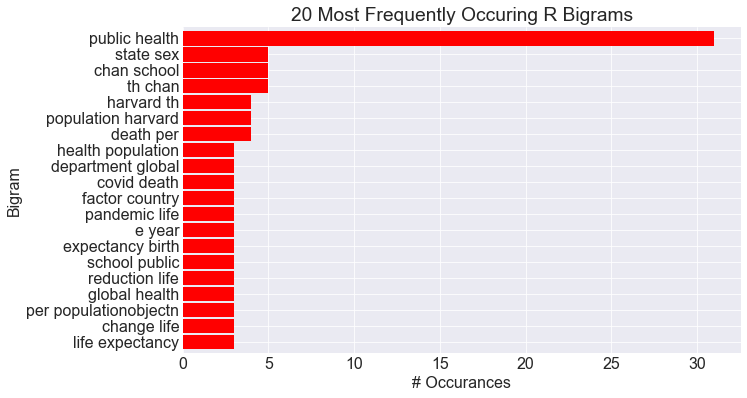

In [81]:
## Plot Top 20 r

top_20_r_bigrams.sort_values().plot.barh(color='red', width=.9, figsize=(10, 6))

plt.title('20 Most Frequently Occuring R Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_r_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

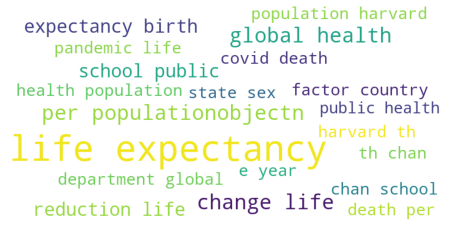

In [82]:
## Create a wordcloud 
data = {k[0] + ' ' + k[1]: v for k, v in top_20_r_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

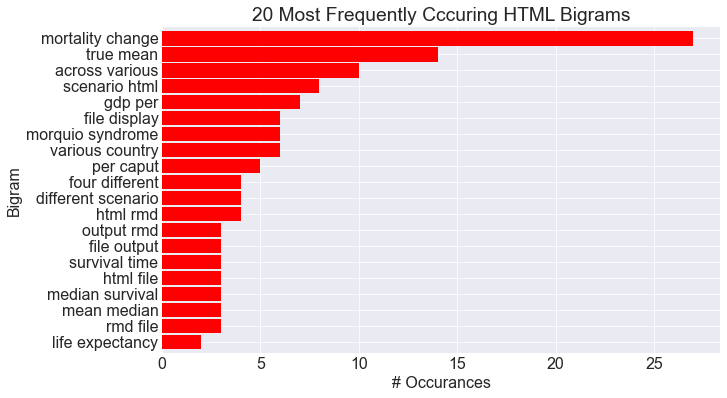

In [83]:
## Plot Top 20 html

top_20_html_bigrams.sort_values().plot.barh(color='red', width=.9, figsize=(10, 6))

plt.title('20 Most Frequently Cccuring HTML Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_html_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

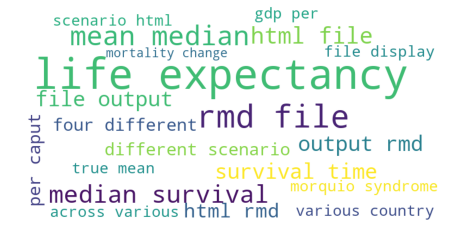

In [84]:
## Create a wordcloud 
data = {k[0] + ' ' + k[1]: v for k, v in top_20_html_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

#### Add Other Features to Explore

In [85]:
#Create a function to get the character count of each doc
def get_char_count(string):
    """
    This function will take in a string and return the number of characters in it.
    """
    
    return len(string)

In [86]:
def get_word_count(string):
    """
    This function will take in a string and return the number of words in that string.
    This function will include repeat words.
    """
    
    #Create a list of words separated by a space
    words = string.split()
    
    return len(words)

In [87]:
def get_unique_words(string):
    """
    This function will take in a string and return the number of unique words in that string.
    """
    
    words = string.split()
    words = set(words)
    
    return len(words)

In [88]:
def get_sentence_count(string):
    """
    This function will take in a string and return the number of sentences in that string.
    """
    
    sentences = nltk.sent_tokenize(string)
    
    return len(sentences)

In [89]:
train['sentence_count'] = train.original.apply(get_unique_words)
train.head()

,repo,language,original,clean,more_clean,char_count,word_count,unique_word_count,clean_contents,sentence_count
77,AntoineGuiot/OWKIN_PROJECT,Python,,,,0,0,0,,0
92,sejaldua/life-expectancy,other,# life-expectancy\nCreating a simple app to vi...,lifeexpectancy creating simple app visualize h...,lifeexpectancy creating simple app visualize h...,102,11,11,lifeexpectancy\ncreating a simple app to visu...,16
94,NEXTSLIM/Life-Expectancy,Python,# Life-Expectancy(DATA ANALYSIS)\nCan we corre...,lifeexpectancydata analysis correctly predict ...,lifeexpectancydata analysis correctly predict ...,973,106,76,lifeexpectancydata analysis\ncan we correctly...,134
16,aleynahukmet/life-expectancy-prediction,Python,"# Life-Expectancy-Prediction\n<p align=""center...",lifeexpectancyprediction p aligncenter img wid...,lifeexpectancyprediction p aligncenter img wid...,3218,400,215,lifeexpectancyprediction\np aligncenter \n ...,369
0,mcastrolab/Brazil-Covid19-e0-change,R,# Reduction in life expectancy in Brazil after...,reduction life expectancy brazil covid provide...,reduction life expectancy brazil covid provide...,2949,352,211,reduction in life expectancy in brazil after ...,314


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   repo               166 non-null    object
 1   language           166 non-null    object
 2   original           166 non-null    object
 3   clean              166 non-null    object
 4   more_clean         166 non-null    object
 5   char_count         166 non-null    int64 
 6   word_count         166 non-null    int64 
 7   unique_word_count  166 non-null    int64 
 8   clean_contents     166 non-null    object
dtypes: int64(3), object(6)
memory usage: 11.8+ KB


In [91]:
train[train['char_count'] <=0]

,repo,language,original,clean,more_clean,char_count,word_count,unique_word_count,clean_contents,sentence_count
77,AntoineGuiot/OWKIN_PROJECT,Python,,,,0,0,0,,0
11,yc244/Stata-code_BMC-Medince2019_Chudasama,other,,,,0,0,0,,0
80,MingXXI/LifeExpectancyLinearModel,other,,,,0,0,0,,0
69,pjmerica/415-final-Project,other,,,,0,0,0,,0
27,emmanuelAkpe/LifeExpectancy,Python,,,,0,0,0,,0
66,t-redactyl/life-expectancy-analysis,Python,,,,0,0,0,,0
58,wrigleyfield/hypotheticalwhite2020mortality,other,,,,0,0,0,,0
158,nsudharsanan/epi_rural_urban_mortality_indonesia,R,,,,0,0,0,,0
106,JeremyMiranda/Life-Expectancy,R,,,,0,0,0,,0
97,Abhinav1092/Life-expectancy,Python,,,,0,0,0,,0


<AxesSubplot:xlabel='language', ylabel='word_count'>

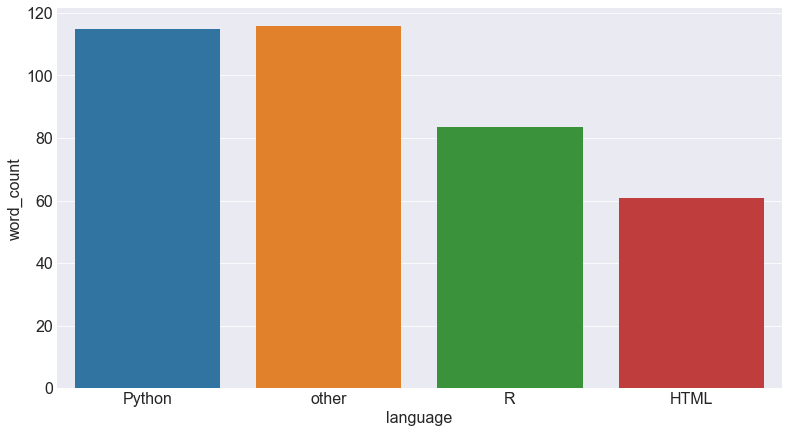

In [92]:
sns.barplot(data=train, y='word_count', x='language', ci=None)

<AxesSubplot:xlabel='language', ylabel='char_count'>

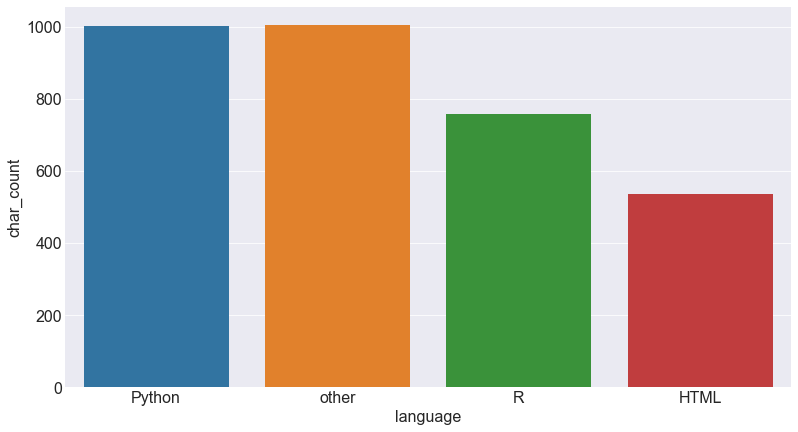

In [93]:
sns.barplot(data=train, y='char_count', x='language', ci=None)

<AxesSubplot:xlabel='language', ylabel='sentence_count'>

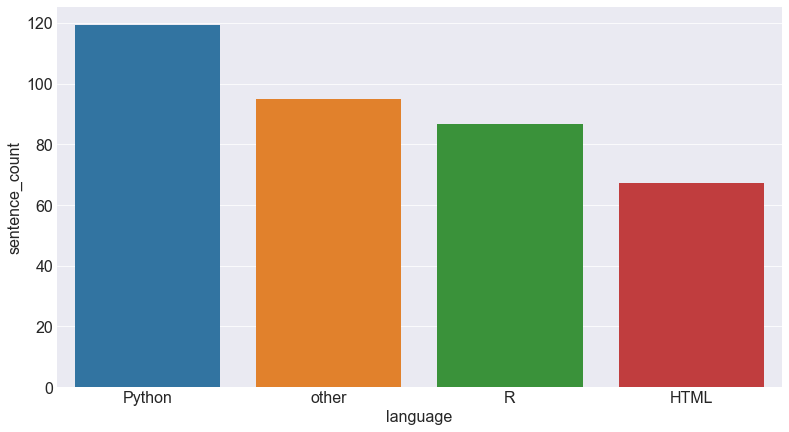

In [94]:
sns.barplot(data=train, y='sentence_count', x='language', ci=None)